In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sentiment-data/data_processing.csv


In [2]:
!pip install spacy
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 69.9 MB/s eta 0:00:0000:010:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [3]:
import spacy
import pandas as pd
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
import nltk

# 下载必要的NLTK资源
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
# 加载spaCy英文模型
nlp = spacy.load('en_core_web_sm')

In [5]:
df = pd.read_csv('/kaggle/input/sentiment-data/data_processing.csv', encoding='ISO-8859-1')
df

,text,sentiment,sentiment_numeric,cleaned_text,work,friend,family
0,is upset that he can't update his Facebook by ...,negative,0,is upset that he cant update his facebook by t...,0,1,1
1,@Kenichan I dived many times for the ball. Man...,negative,0,kenichan i dived many times for the ball manag...,0,1,0
2,my whole body feels itchy and like its on fire,negative,0,my whole body feels itchy and like its on fire,0,1,1
3,"@nationwideclass no, it's not behaving at all....",negative,0,nationwideclass no its not behaving at all im ...,0,1,0
4,@Kwesidei not the whole crew,negative,0,kwesidei not the whole crew,0,1,0
...,...,...,...,...,...,...,...
1574706,Just woke up. Having no school is the best fee...,positive,1,just woke up having no school is the best feel...,0,0,0
1574707,TheWDB.com - Very cool to hear old Walt interv...,positive,1,thewdbcom very cool to hear old walt interviews,0,0,0
1574708,Are you ready for your MoJo Makeover? Ask me f...,positive,1,are you ready for your mojo makeover ask me fo...,0,0,0
1574709,Happy 38th Birthday to my boo of alll time!!! ...,positive,1,happy th birthday to my boo of alll time tupac...,0,0,0


In [6]:
df['cleaned_text'] = df['cleaned_text'].fillna('')
df['cleaned_text'] = df['cleaned_text'].astype(str)

In [7]:
top10_percent_count = int(len(df) * 0.1)
top10_df = df.head(top10_percent_count)
top10_df

,text,sentiment,sentiment_numeric,cleaned_text,work,friend,family
0,is upset that he can't update his Facebook by ...,negative,0,is upset that he cant update his facebook by t...,0,1,1
1,@Kenichan I dived many times for the ball. Man...,negative,0,kenichan i dived many times for the ball manag...,0,1,0
2,my whole body feels itchy and like its on fire,negative,0,my whole body feels itchy and like its on fire,0,1,1
3,"@nationwideclass no, it's not behaving at all....",negative,0,nationwideclass no its not behaving at all im ...,0,1,0
4,@Kwesidei not the whole crew,negative,0,kwesidei not the whole crew,0,1,0
...,...,...,...,...,...,...,...
157466,I just noticed how clear my face is becoming. ...,negative,0,i just noticed how clear my face is becoming d...,0,1,0
157467,I do NOT know how to freelance.,negative,0,i do not know how to freelance,0,1,0
157468,"ZK-JND is my stead, we are currenty running 20...",negative,0,zkjnd is my stead we are currenty running min...,0,1,0
157469,is not even winter yet and its vrek cold and r...,negative,0,is not even winter yet and its vrek cold and r...,0,1,0


## Define Lemmatization and Stemming processing functions

In [8]:
# Initialize the PorterStemmer
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()

# Lemmatization
def lemmatize_text(text):
    doc = nlp(text)
    return ' '.join([token.lemma_ for token in doc])

# Stemming
def stem_text(text):
    tokens = text.split()
    return ' '.join([stemmer.stem(token) for token in tokens])


top10_df['lemmatized_text'] = top10_df['cleaned_text'].apply(lemmatize_text)
top10_df['stemmed_text'] = top10_df['cleaned_text'].apply(stem_text)


top10_df[['lemmatized_text', 'stemmed_text']].head()

/tmp/ipykernel_36/3349893856.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top10_df['lemmatized_text'] = top10_df['cleaned_text'].apply(lemmatize_text)
/tmp/ipykernel_36/3349893856.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top10_df['stemmed_text'] = top10_df['cleaned_text'].apply(stem_text)


,lemmatized_text,stemmed_text
0,be upset that he can not update his facebook b...,is upset that he cant updat hi facebook by tex...
1,kenichan I dive many time for the ball manage ...,kenichan i dive mani time for the ball manag t...
2,my whole body feel itchy and like its on fire,my whole bodi feel itchi and like it on fire
3,nationwideclass no its not behave at all I m m...,nationwideclass no it not behav at all im mad ...
4,kwesidei not the whole crew,kwesidei not the whole crew


In [9]:
top10_df

,text,sentiment,sentiment_numeric,cleaned_text,work,friend,family,lemmatized_text,stemmed_text
0,is upset that he can't update his Facebook by ...,negative,0,is upset that he cant update his facebook by t...,0,1,1,be upset that he can not update his facebook b...,is upset that he cant updat hi facebook by tex...
1,@Kenichan I dived many times for the ball. Man...,negative,0,kenichan i dived many times for the ball manag...,0,1,0,kenichan I dive many time for the ball manage ...,kenichan i dive mani time for the ball manag t...
2,my whole body feels itchy and like its on fire,negative,0,my whole body feels itchy and like its on fire,0,1,1,my whole body feel itchy and like its on fire,my whole bodi feel itchi and like it on fire
3,"@nationwideclass no, it's not behaving at all....",negative,0,nationwideclass no its not behaving at all im ...,0,1,0,nationwideclass no its not behave at all I m m...,nationwideclass no it not behav at all im mad ...
4,@Kwesidei not the whole crew,negative,0,kwesidei not the whole crew,0,1,0,kwesidei not the whole crew,kwesidei not the whole crew
...,...,...,...,...,...,...,...,...,...
157466,I just noticed how clear my face is becoming. ...,negative,0,i just noticed how clear my face is becoming d...,0,1,0,I just notice how clear my face be become down...,i just notic how clear my face is becom downsi...
157467,I do NOT know how to freelance.,negative,0,i do not know how to freelance,0,1,0,I do not know how to freelance,i do not know how to freelanc
157468,"ZK-JND is my stead, we are currenty running 20...",negative,0,zkjnd is my stead we are currenty running min...,0,1,0,zkjnd be my stead we be currenty run min late,zkjnd is my stead we are currenti run min late
157469,is not even winter yet and its vrek cold and r...,negative,0,is not even winter yet and its vrek cold and r...,0,1,0,be not even winter yet and its vrek cold and rain,is not even winter yet and it vrek cold and rain


## TF-IDF feature extraction

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer


In [11]:
# Define the TF-IDF vectorizer with a maximum of 5000 features
tfidf = TfidfVectorizer(max_features=5000, stop_words='english')

X_lemmatized_tfidf = tfidf.fit_transform(top10_df['lemmatized_text'])

X_stemmed_tfidf = tfidf.fit_transform(top10_df['stemmed_text'])
y_work = top10_df['work']
y_family = top10_df['family']
y_friend = top10_df['friend']

In [12]:
# Group the data by scene labels
work_text = top10_df[top10_df['work'] == 1]['lemmatized_text']
family_text = top10_df[top10_df['family'] == 1]['lemmatized_text']
friend_text = top10_df[top10_df['friend'] == 1]['lemmatized_text']

# Perform TF-IDF feature extraction for each scene separately
tfidf_work = tfidf.fit_transform(work_text)
tfidf_family = tfidf.fit_transform(family_text)
tfidf_friend = tfidf.fit_transform(friend_text)

In [13]:
# Extract vocabulary and TF-IDF weights
words_work = tfidf.get_feature_names_out()
scores_work = tfidf_work.sum(axis=0).A1  

words_family = tfidf.get_feature_names_out()
scores_family = tfidf_family.sum(axis=0).A1  

words_friend = tfidf.get_feature_names_out()
scores_friend = tfidf_friend.sum(axis=0).A1 

In [14]:
# Create DataFrames and sort by weights
tfidf_df_work = pd.DataFrame({'Word': words_work, 'TF-IDF Score': scores_work})
tfidf_df_family = pd.DataFrame({'Word': words_family, 'TF-IDF Score': scores_family})
tfidf_df_friend = pd.DataFrame({'Word': words_friend, 'TF-IDF Score': scores_friend})

# Sort and display the high weight words in each scene (take the top 20)
tfidf_top_work = tfidf_df_work.sort_values(by='TF-IDF Score', ascending=False).head(20)
tfidf_top_family = tfidf_df_family.sort_values(by='TF-IDF Score', ascending=False).head(20)
tfidf_top_friend = tfidf_df_friend.sort_values(by='TF-IDF Score', ascending=False).head(20)

In [15]:
print("High-weight words for work scenarios：\n", tfidf_top_work)
print("High-weight words for family scenes：\n", tfidf_top_family)
print("High-weight words for friend scenarios：\n", tfidf_top_friend)

High-weight words for work scenarios：
             Word  TF-IDF Score
4847        wide   1562.528985
1061  dannymcfly    479.760957
4389      thesis    364.437174
2021     holland    314.365926
4415        thur    280.601149
2311          ka    279.671647
4719     vehicle    253.518781
2268         joe    230.228366
4358  terminator    230.102302
2016         hol    223.440050
2970      nugget    209.630182
2781     montana    189.399975
2862     naughty    189.282203
2056        hour    182.901826
1795         gon    179.430258
3902     simpson    178.158735
2477       light    176.560449
4754          vs    174.156698
4756      waaaay    169.723332
3462        raid    168.287049
High-weight words for family scenes：
           Word  TF-IDF Score
1545     fella   1268.351341
3741     scary   1075.802023
2034       hoo   1008.007804
2514      loan    529.293605
1089  deadline    508.360454
2342       kid    506.727946
4464      todo    428.919759
2821       mtv    423.598267
1799   good

## Training Models

In [50]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.multioutput import MultiOutputClassifier

In [48]:
y = top10_df[['work', 'friend', 'family']]

In [51]:
# code from https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
rf_model = MultiOutputClassifier(RandomForestClassifier(random_state=42))

# code from https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
logreg_model = MultiOutputClassifier(LogisticRegression(max_iter=1000))

# code from https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html
nb_model = MultiOutputClassifier(MultinomialNB())

In [52]:
X_train_lem, X_test_lem, y_train, y_test = train_test_split(X_lemmatized_tfidf, y, test_size=0.2, random_state=42)
X_train_stem, X_test_stem, y_train, y_test = train_test_split(X_stemmed_tfidf, y, test_size=0.2, random_state=42)

In [53]:
# Defining the training and evaluation function
def train_and_evaluate(X_train, X_test, y_train, y_test, model, model_name, preprocessing_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    print(f"=== {preprocessing_name} - {model_name} ===")
    print(classification_report(y_test, y_pred))
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy: ", accuracy)
    print("=" * 50)
    
    return accuracy

In [54]:
# Define the accuracy dictionary
metrics = {
    'Lemmatized': {'Random Forest': {}, 'Logistic Regression': {}, 'Naive Bayes': {}},
    'Stemmed': {'Random Forest': {}, 'Logistic Regression': {}, 'Naive Bayes': {}}
}

# Train and evaluate using Lemmatized data
accuracy_rf_lem = train_and_evaluate(X_train_lem, X_test_lem, y_train, y_test, rf_model, "Random Forest", "Lemmatized")
accuracy_logreg_lem = train_and_evaluate(X_train_lem, X_test_lem, y_train, y_test, logreg_model, "Logistic Regression", "Lemmatized")
accuracy_nb_lem = train_and_evaluate(X_train_lem, X_test_lem, y_train, y_test, nb_model, "Naive Bayes", "Lemmatized")

# Store the results for Lemmatized
metrics['Lemmatized']['Random Forest'] = accuracy_rf_lem
metrics['Lemmatized']['Logistic Regression'] = accuracy_logreg_lem
metrics['Lemmatized']['Naive Bayes'] = accuracy_nb_lem

print("=== Lemmatized Results ===")
print(f"Random Forest Accuracy: {metrics['Lemmatized']['Random Forest']}")
print(f"Logistic Regression Accuracy: {metrics['Lemmatized']['Logistic Regression']}")
print(f"Naive Bayes Accuracy: {metrics['Lemmatized']['Naive Bayes']}")

# Train and evaluate using Stemmed data
accuracy_rf_stem = train_and_evaluate(X_train_stem, X_test_stem, y_train, y_test, rf_model, "Random Forest", "Stemmed")
accuracy_logreg_stem = train_and_evaluate(X_train_stem, X_test_stem, y_train, y_test, logreg_model, "Logistic Regression", "Stemmed")
accuracy_nb_stem = train_and_evaluate(X_train_stem, X_test_stem, y_train, y_test, nb_model, "Naive Bayes", "Stemmed")

# Store the results for Stemmed
metrics['Stemmed']['Random Forest'] = accuracy_rf_stem
metrics['Stemmed']['Logistic Regression'] = accuracy_logreg_stem
metrics['Stemmed']['Naive Bayes'] = accuracy_nb_stem

print("\n=== Stemmed Results ===")
print(f"Random Forest Accuracy: {metrics['Stemmed']['Random Forest']}")
print(f"Logistic Regression Accuracy: {metrics['Stemmed']['Logistic Regression']}")
print(f"Naive Bayes Accuracy: {metrics['Stemmed']['Naive Bayes']}")

=== Lemmatized - Random Forest ===
              precision    recall  f1-score   support

           0       1.00      0.96      0.98      3077
           1       0.99      0.99      0.99     27178
           2       0.99      0.95      0.97      4747

   micro avg       0.99      0.99      0.99     35002
   macro avg       0.99      0.97      0.98     35002
weighted avg       0.99      0.99      0.99     35002
 samples avg       0.99      0.99      0.99     35002

Accuracy:  0.9824734084775362


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


=== Lemmatized - Logistic Regression ===
              precision    recall  f1-score   support

           0       1.00      0.93      0.96      3077
           1       0.98      0.99      0.99     27178
           2       0.98      0.92      0.95      4747

   micro avg       0.98      0.98      0.98     35002
   macro avg       0.99      0.95      0.97     35002
weighted avg       0.98      0.98      0.98     35002
 samples avg       0.99      0.98      0.98     35002

Accuracy:  0.9691379584060962
=== Lemmatized - Naive Bayes ===
              precision    recall  f1-score   support

           0       1.00      0.63      0.77      3077
           1       0.90      1.00      0.95     27178
           2       0.99      0.50      0.66      4747

   micro avg       0.91      0.90      0.91     35002
   macro avg       0.96      0.71      0.80     35002
weighted avg       0.92      0.90      0.89     35002
 samples avg       0.93      0.92      0.92     35002

Accuracy:  0.8425464359422

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


=== Stemmed - Random Forest ===
              precision    recall  f1-score   support

           0       1.00      0.94      0.97      3077
           1       0.99      0.99      0.99     27178
           2       0.98      0.95      0.97      4747

   micro avg       0.99      0.98      0.99     35002
   macro avg       0.99      0.96      0.98     35002
weighted avg       0.99      0.98      0.99     35002
 samples avg       0.99      0.99      0.99     35002

Accuracy:  0.9794570566756629


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


=== Stemmed - Logistic Regression ===
              precision    recall  f1-score   support

           0       1.00      0.92      0.95      3077
           1       0.98      0.99      0.99     27178
           2       0.98      0.91      0.95      4747

   micro avg       0.98      0.98      0.98     35002
   macro avg       0.99      0.94      0.96     35002
weighted avg       0.98      0.98      0.98     35002
 samples avg       0.98      0.98      0.98     35002

Accuracy:  0.9663756151770122
=== Stemmed - Naive Bayes ===
              precision    recall  f1-score   support

           0       1.00      0.57      0.73      3077
           1       0.90      1.00      0.95     27178
           2       0.99      0.47      0.64      4747

   micro avg       0.91      0.89      0.90     35002
   macro avg       0.96      0.68      0.77     35002
weighted avg       0.92      0.89      0.89     35002
 samples avg       0.93      0.91      0.91     35002

Accuracy:  0.8340371487537704

=

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Visualize the Results

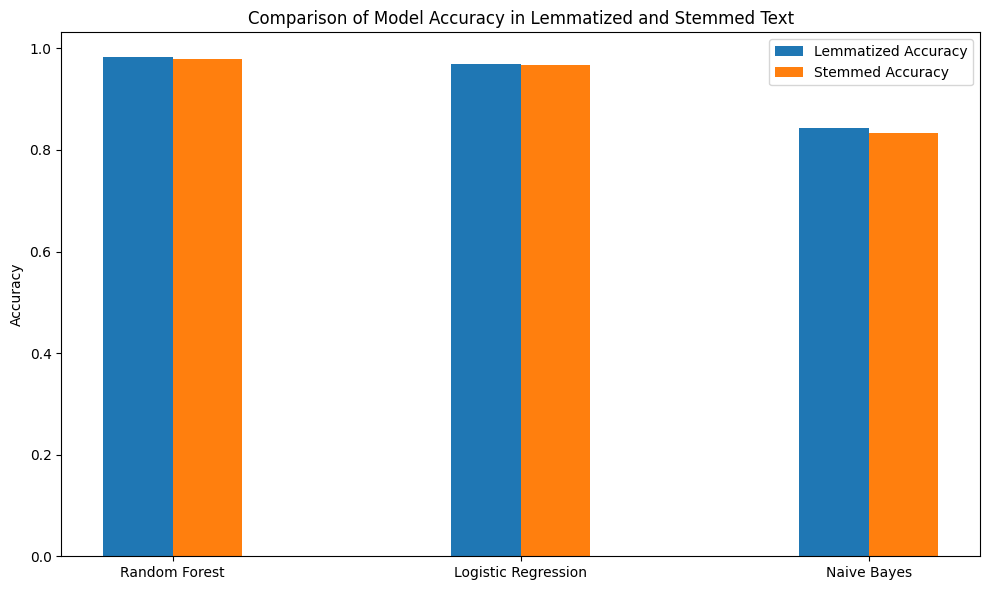

In [58]:
labels = ['Random Forest', 'Logistic Regression', 'Naive Bayes']
x = np.arange(len(labels))  
width = 0.2  

fig, ax = plt.subplots(figsize=(10, 6))

# plot the accuracy
accuracy_lem = [metrics['Lemmatized'][model] for model in labels]
accuracy_stem = [metrics['Stemmed'][model] for model in labels]
rects1 = ax.bar(x - width/2, accuracy_lem, width, label='Lemmatized Accuracy')
rects2 = ax.bar(x + width/2, accuracy_stem, width, label='Stemmed Accuracy')

ax.set_ylabel('Accuracy')
ax.set_title('Comparison of Model Accuracy in Lemmatized and Stemmed Text')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()
plt.show()

## Save the Best Model (Lemmatization + Random Forest)

In [59]:
import joblib

# Save the best model
joblib.dump(rf_model, 'random_forest_lemmatized_model.pkl')

print("Random Forest：'random_forest_lemmatized_model.pkl'")

Random Forest：'random_forest_lemmatized_model.pkl'


## The remaining 90 data without scenes

In [26]:
# 提取剩余 90% 的数据
total_rows = len(df)
remaining90_df = df[int(total_rows * 0.1):]  # 剩下的90%数据

# 验证数据分割
print(f"total: {total_rows}")
print(f"The remaining 90% of rows extracted: {len(remaining90_df)}")

remaining90_df



total: 1574711
The remaining 90% of rows extracted: 1417240


,text,sentiment,sentiment_numeric,cleaned_text,work,friend,family
157471,Yuli! why did u delete ur facebook account?,negative,0,yuli why did u delete ur facebook account,0,0,0
157472,@kittylair Did you break David? That would m...,negative,0,kittylair did you break david that would mak...,0,0,0
157473,@paulelgin Making fun of me.,negative,0,paulelgin making fun of me,0,0,0
157474,@BaKKaNeKKo probably as heavy and as expensive...,negative,0,bakkanekko probably as heavy and as expensive ...,0,0,0
157475,@_Qualia what? scones HAVE Olives.... eeeeek ...,negative,0,qualia what scones have olives eeeeek why not...,0,0,0
...,...,...,...,...,...,...,...
1574706,Just woke up. Having no school is the best fee...,positive,1,just woke up having no school is the best feel...,0,0,0
1574707,TheWDB.com - Very cool to hear old Walt interv...,positive,1,thewdbcom very cool to hear old walt interviews,0,0,0
1574708,Are you ready for your MoJo Makeover? Ask me f...,positive,1,are you ready for your mojo makeover ask me fo...,0,0,0
1574709,Happy 38th Birthday to my boo of alll time!!! ...,positive,1,happy th birthday to my boo of alll time tupac...,0,0,0


In [27]:
from tqdm import tqdm
# code from https://stackoverflow.com/questions/40476680/how-to-use-tqdm-with-pandas-in-a-jupyter-notebook
tqdm.pandas()


In [28]:
# Lemmatize the cleaned_text column of the remaining 90% data and display the progress
remaining90_df['lemmatized_text'] = remaining90_df['cleaned_text'].progress_apply(lemmatize_text)

100%|██████████| 1417240/1417240 [2:34:14<00:00, 153.14it/s]  
/tmp/ipykernel_36/666173577.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  remaining90_df['lemmatized_text'] = remaining90_df['cleaned_text'].progress_apply(lemmatize_text)


In [60]:
# Load the model
rf_model_loaded = joblib.load('random_forest_lemmatized_model.pkl')


In [61]:
# Use TF-IDF for feature extraction
tfidf = TfidfVectorizer(max_features=5000) 
X_remaining_90 = tfidf.fit_transform(remaining90_df['lemmatized_text'])

# Load the model to predict the scene
predictions = rf_model_loaded.predict(X_remaining_90)

remaining90_df['work'] = predictions[:, 0]  
remaining90_df['friend'] = predictions[:, 1]  
remaining90_df['family'] = predictions[:, 2]  

/tmp/ipykernel_36/14697985.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  remaining90_df['work'] = predictions[:, 0]  # 假设第一个标签是工作
/tmp/ipykernel_36/14697985.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  remaining90_df['friend'] = predictions[:, 1]  # 假设第二个标签是朋友
/tmp/ipykernel_36/14697985.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.p

In [62]:
remaining90_df

,text,sentiment,sentiment_numeric,cleaned_text,work,friend,family,lemmatized_text
157471,Yuli! why did u delete ur facebook account?,negative,0,yuli why did u delete ur facebook account,0,1,0,yuli why do u delete ur facebook account
157472,@kittylair Did you break David? That would m...,negative,0,kittylair did you break david that would mak...,0,1,0,kittylair do you break david that would ma...
157473,@paulelgin Making fun of me.,negative,0,paulelgin making fun of me,0,1,0,paulelgin make fun of I
157474,@BaKKaNeKKo probably as heavy and as expensive...,negative,0,bakkanekko probably as heavy and as expensive ...,0,1,0,bakkanekko probably as heavy and as expensive ...
157475,@_Qualia what? scones HAVE Olives.... eeeeek ...,negative,0,qualia what scones have olives eeeeek why not...,0,1,0,qualia what scone have olive eeeeek why not ...
...,...,...,...,...,...,...,...,...
1574706,Just woke up. Having no school is the best fee...,positive,1,just woke up having no school is the best feel...,0,1,0,just wake up have no school be the good feelin...
1574707,TheWDB.com - Very cool to hear old Walt interv...,positive,1,thewdbcom very cool to hear old walt interviews,0,1,0,thewdbcom very cool to hear old walt interview
1574708,Are you ready for your MoJo Makeover? Ask me f...,positive,1,are you ready for your mojo makeover ask me fo...,0,1,0,be you ready for your mojo makeover ask I for ...
1574709,Happy 38th Birthday to my boo of alll time!!! ...,positive,1,happy th birthday to my boo of alll time tupac...,0,1,0,happy th birthday to my boo of alll time tupac...


## Complete Database with Scenarios

In [63]:
# combined the top 10% and the remaining 90% data
combined_df = pd.concat([top10_df, remaining90_df], ignore_index=True)
combined_df

,text,sentiment,sentiment_numeric,cleaned_text,work,friend,family,lemmatized_text,stemmed_text
0,is upset that he can't update his Facebook by ...,negative,0,is upset that he cant update his facebook by t...,0,1,1,be upset that he can not update his facebook b...,is upset that he cant updat hi facebook by tex...
1,@Kenichan I dived many times for the ball. Man...,negative,0,kenichan i dived many times for the ball manag...,0,1,0,kenichan I dive many time for the ball manage ...,kenichan i dive mani time for the ball manag t...
2,my whole body feels itchy and like its on fire,negative,0,my whole body feels itchy and like its on fire,0,1,1,my whole body feel itchy and like its on fire,my whole bodi feel itchi and like it on fire
3,"@nationwideclass no, it's not behaving at all....",negative,0,nationwideclass no its not behaving at all im ...,0,1,0,nationwideclass no its not behave at all I m m...,nationwideclass no it not behav at all im mad ...
4,@Kwesidei not the whole crew,negative,0,kwesidei not the whole crew,0,1,0,kwesidei not the whole crew,kwesidei not the whole crew
...,...,...,...,...,...,...,...,...,...
1574706,Just woke up. Having no school is the best fee...,positive,1,just woke up having no school is the best feel...,0,1,0,just wake up have no school be the good feelin...,NaN
1574707,TheWDB.com - Very cool to hear old Walt interv...,positive,1,thewdbcom very cool to hear old walt interviews,0,1,0,thewdbcom very cool to hear old walt interview,NaN
1574708,Are you ready for your MoJo Makeover? Ask me f...,positive,1,are you ready for your mojo makeover ask me fo...,0,1,0,be you ready for your mojo makeover ask I for ...,NaN
1574709,Happy 38th Birthday to my boo of alll time!!! ...,positive,1,happy th birthday to my boo of alll time tupac...,0,1,0,happy th birthday to my boo of alll time tupac...,NaN


In [65]:
work_count = combined_df['work'].value_counts()
friend_count = combined_df['friend'].value_counts()
family_count = combined_df['family'].value_counts()
print(work_count,friend_count,family_count)

work
0    1544130
1      30581
Name: count, dtype: int64 friend
1    1519265
0      55446
Name: count, dtype: int64 family
0    1522402
1      52309
Name: count, dtype: int64


In [68]:
# Count the number of rows where all three scenes are 0
zero_scenes_count = combined_df[(combined_df['work'] == 0) & (combined_df['friend'] == 0) & (combined_df['family'] == 0)].shape[0]

# 打印结果
print(zero_scenes_count)

139


In [69]:
# Drop all rows where all three scenes are 0
combined_df_cleaned = combined_df[~((combined_df['work'] == 0) & (combined_df['friend'] == 0) & (combined_df['family'] == 0))]

combined_df_cleaned.shape

(1574572, 9)

In [70]:
work_sentiment_count = combined_df_cleaned.groupby(['work', 'sentiment_numeric']).size().unstack(fill_value=0)
friend_sentiment_count = combined_df_cleaned.groupby(['friend', 'sentiment_numeric']).size().unstack(fill_value=0)
family_sentiment_count = combined_df_cleaned.groupby(['family', 'sentiment_numeric']).size().unstack(fill_value=0)


print("Work emotion distribution in the scene:\n", work_sentiment_count)
print("\nFriend emotion distribution in the scene:\n", friend_sentiment_count)
print("\nFamily emotion distribution in the scene:\n", family_sentiment_count)

Work emotion distribution in the scene:
 sentiment_numeric       0       1
work                             
0                  764940  779051
1                   21427    9154

Friend emotion distribution in the scene:
 sentiment_numeric       0       1
friend                           
0                   36332   18975
1                  750035  769230

Family emotion distribution in the scene:
 sentiment_numeric       0       1
family                           
0                  749053  773210
1                   37314   14995


In [75]:
work_count = combined_df_cleaned['work'].value_counts()
friend_count = combined_df_cleaned['friend'].value_counts()
family_count = combined_df_cleaned['family'].value_counts()
print(work_count,friend_count,family_count)

work
0    1543991
1      30581
Name: count, dtype: int64 friend
1    1519265
0      55307
Name: count, dtype: int64 family
0    1522263
1      52309
Name: count, dtype: int64


In [96]:
combined_df_cleaned.to_csv('cleaned_data.csv', index=False)

## Take the Work Scenario as an Example

In [86]:
work_scene_df = combined_df_cleaned[combined_df['work'] == 1]

/tmp/ipykernel_36/276164170.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  work_scene_df = combined_df_cleaned[combined_df['work'] == 1]


In [87]:
tfidf = TfidfVectorizer(max_features=5000, stop_words='english')

# Extract TF-IDF features for text in the work scenario
X_work_tfidf = tfidf.fit_transform(work_scene_df['cleaned_text'])

# Extract feature names (vocabulary)
words_work = tfidf.get_feature_names_out()

# Calculate the total TF-IDF score for each word
scores_work = X_work_tfidf.sum(axis=0).A1

# Create a DataFrame and sort by TF-IDF score
tfidf_df_work = pd.DataFrame({'Word': words_work, 'TF-IDF Score': scores_work})
tfidf_top_work = tfidf_df_work.sort_values(by='TF-IDF Score', ascending=False).head(20)

# Print high-weight words (top 20)
print("Top 30 high-weight words in work scenario:\n", tfidf_top_work)

Top 30 high-weight words in work scenario:
           Word  TF-IDF Score
4865      work   1819.046616
2152        im    829.805446
1221      dont    710.301939
4877   working    643.591750
4908     worth    640.413140
2308      just    591.094545
1064       day    577.876477
4901     worry    574.490932
4403     today    469.356862
4899   worried    423.114962
1766     going    379.178107
1788       got    370.199743
4378      time    355.332445
4422  tomorrow    348.845210
2485      like    348.159460
1775      good    341.519683
4900   worries    328.596823
2043  homework    320.502815
3475    really    309.479087
2283      joke    308.780217


### Filter text with negative emotions (sentiment_numeric is 0)

In [88]:
# Filter text with negative emotions (sentiment_numeric is 0)
negative_work_text = work_scene_df[work_scene_df['sentiment_numeric'] == 0]['cleaned_text']

# Extract TF-IDF features for text in the work scenario with negative emotions
X_negative_work_tfidf = tfidf.fit_transform(negative_work_text)

# Calculate the total TF-IDF score for each word
scores_negative_work = X_negative_work_tfidf.sum(axis=0).A1

# Create a DataFrame and sort by TF-IDF score
tfidf_df_negative_work = pd.DataFrame({'Word': words_work, 'TF-IDF Score': scores_negative_work})
tfidf_top_negative_work = tfidf_df_negative_work.sort_values(by='TF-IDF Score', ascending=False).head(20)

print("Top 20 high-weight words in negative work scenario:\n", tfidf_top_negative_work)

Top 30 high-weight words in negative work scenario:
                  Word  TF-IDF Score
4851           wonder   1554.669731
2151              ily    622.480366
4868          workday    582.724753
1042        dangerous    471.200880
4370          tidying    397.775199
2333              kid    379.325868
1202             dock    377.577182
4901            worry    335.719556
1778         goodness    302.140557
2035        hollywood    301.319384
4390            tired    300.043666
1800             grab    273.565835
4343           thomas    260.036061
2030             hole    257.416119
4701            voice    241.290186
3478       reasonable    241.134127
4908            worth    237.879905
2511             live    234.850729
2290  jonathanrknight    232.307467
2963         november    220.404989


### Filter text with positive emotions (sentiment_numeric is 1)

In [89]:
positive_work_text = work_scene_df[work_scene_df['sentiment_numeric'] == 1]['cleaned_text']

X_positive_work_tfidf = tfidf.fit_transform(positive_work_text)

scores_positive_work = X_positive_work_tfidf.sum(axis=0).A1

tfidf_df_positive_work = pd.DataFrame({'Word': words_work, 'TF-IDF Score': scores_positive_work})
tfidf_top_positive_work = tfidf_df_positive_work.sort_values(by='TF-IDF Score', ascending=False).head(20)

print("Top 20 high-weight words in positive work scenario:\n", tfidf_top_positive_work)

Top 30 high-weight words in positive work scenario:
             Word  TF-IDF Score
4920     writers    344.835640
4912         wot    331.264553
1213        doll    319.317462
4911       wossy    236.640552
2315       karma    209.944861
2098       hubby    208.554290
2281        join    141.711864
3064          ow    141.580711
2568        love    135.567663
1720        gets    133.739293
2509  literature    113.194718
4371         tie    109.711960
2604      mainly    106.853983
1054        date    104.874493
2396        lake     99.673698
4436       tonys     97.141819
1736       gimme     96.388832
2978       oasis     92.347942
2091          hq     89.294196
1819    graphics     87.434316


## Extract TF-IDF Features for Each Scenario

In [90]:
tfidf = TfidfVectorizer(max_features=20, stop_words='english') # Limit the keywords to 20 and exclude common stop words

# Extract TF-IDF features for each scene
work_text = combined_df_cleaned[combined_df_cleaned['work'] == 1]['cleaned_text']
family_text = combined_df_cleaned[combined_df_cleaned['family'] == 1]['cleaned_text']
friend_text = combined_df_cleaned[combined_df_cleaned['friend'] == 1]['cleaned_text']

# Perform TF-IDF feature extraction for each scene separately
tfidf_work = tfidf.fit_transform(work_text)
tfidf_family = tfidf.fit_transform(family_text)
tfidf_friend = tfidf.fit_transform(friend_text)

# Extract vocabulary and TF-IDF weights
work_words = tfidf.get_feature_names_out()
work_scores = tfidf_work.sum(axis=0).A1

family_words = tfidf.get_feature_names_out()
family_scores = tfidf_family.sum(axis=0).A1

friend_words = tfidf.get_feature_names_out()
friend_scores = tfidf_friend.sum(axis=0).A1

In [91]:
tfidf_work_df = pd.DataFrame({'Word': work_words, 'TF-IDF Score': work_scores}).sort_values(by='TF-IDF Score', ascending=False)
tfidf_family_df = pd.DataFrame({'Word': family_words, 'TF-IDF Score': family_scores}).sort_values(by='TF-IDF Score', ascending=False)
tfidf_friend_df = pd.DataFrame({'Word': friend_words, 'TF-IDF Score': friend_scores}).sort_values(by='TF-IDF Score', ascending=False)

### Draw Charts

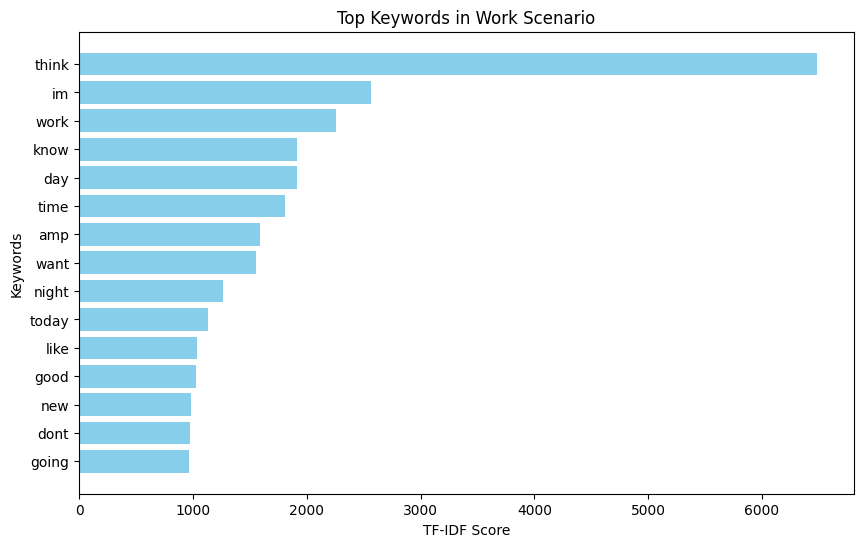

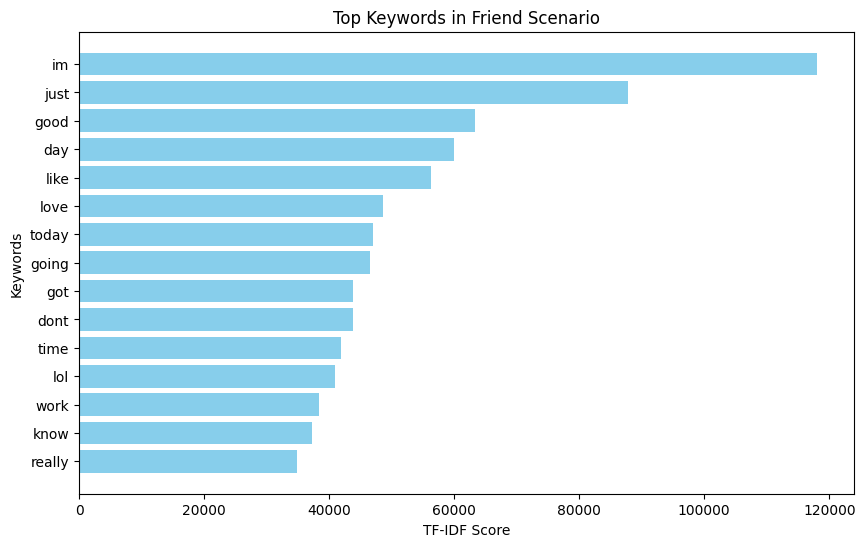

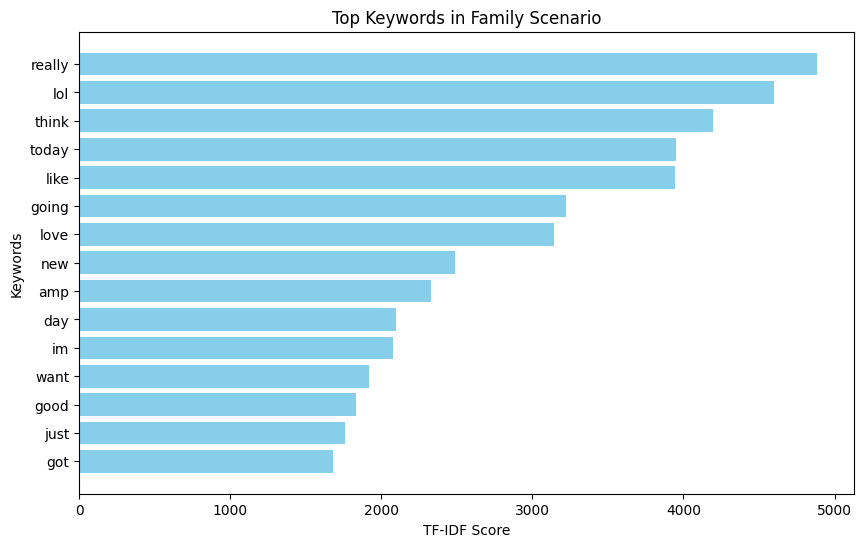

In [94]:
def plot_top_keywords(tfidf_df, scene_label):
    plt.figure(figsize=(10, 6))
    plt.barh(tfidf_df['Word'], tfidf_df['TF-IDF Score'], color='skyblue')
    plt.xlabel('TF-IDF Score')
    plt.ylabel('Keywords')
    plt.title(f'Top Keywords in {scene_label} Scenario')
    plt.gca().invert_yaxis()  # Reverse the Y-axis so that the keywords with high scores are at the top
    plt.show()

plot_top_keywords(tfidf_work_df.head(15), 'Work')
plot_top_keywords(tfidf_friend_df.head(15), 'Friend')
plot_top_keywords(tfidf_family_df.head(15), 'Family')

## Balancing Each Scenario data

In [83]:
from sklearn.utils import resample
# code from https://scikit-learn.org/stable/modules/generated/sklearn.utils.resample.html
# Define the target sample size
target_sample_size = 30000

# Sample the 1 in the work scenario
work_1 = combined_df_cleaned[combined_df_cleaned['work'] == 1]
work_sampled_1 = resample(work_1, replace=False, n_samples=target_sample_size, random_state=42)

# Sample the 1 in the friend scenario
friend_1 = combined_df_cleaned[combined_df_cleaned['friend'] == 1]
friend_sampled_1 = resample(friend_1, replace=False, n_samples=target_sample_size, random_state=42)

# Sample the 1 in the family scenario
family_1 = combined_df_cleaned[combined_df_cleaned['family'] == 1]
family_sampled_1 = resample(family_1, replace=False, n_samples=target_sample_size, random_state=42)

# Combine the sampled data
balanced_df = pd.concat([work_sampled_1, friend_sampled_1, family_sampled_1])

print(balanced_df['work'].value_counts())
print(balanced_df['friend'].value_counts())
print(balanced_df['family'].value_counts())

work
0    58291
1    31709
Name: count, dtype: int64
friend
0    45600
1    44400
Name: count, dtype: int64
family
0    56744
1    33256
Name: count, dtype: int64


In [95]:
balanced_df.to_csv('balanced_data.csv', index=False)

In [85]:
balanced_df

,text,sentiment,sentiment_numeric,cleaned_text,work,friend,family,lemmatized_text,stemmed_text
1096481,btw my last tweet was supposed to say @jackall...,positive,1,btw my last tweet was supposed to say jackallt...,1,0,0,btw my last tweet be suppose to say jackalltim...,NaN
1331104,thank god the weekend is here. five more days ...,positive,1,thank god the weekend is here five more days ...,1,0,0,thank god the weekend be here five more day ...,NaN
36969,2am... still working. at this rate i'll nev...,negative,0,am still working at this rate ill never get...,1,0,0,be still work at this rate ill never get r...,am still work at thi rate ill never get rid of...
85000,This is going to be a long ass day of work.,negative,0,this is going to be a long ass day of work,1,0,0,this be go to be a long ass day of work,thi is go to be a long ass day of work
104267,Threw out the right side of my back by simply ...,negative,0,threw out the right side of my back by simply ...,1,0,0,throw out the right side of my back by simply ...,threw out the right side of my back by simpli ...
...,...,...,...,...,...,...,...,...,...
771413,@mrhorse The problem is that universities are ...,negative,0,mrhorse the problem is that universities are a...,0,1,1,mrhorse the problem be that university be also...,NaN
348273,@brinckey7 dont bother urself..no students wer...,negative,0,brinckey dont bother urselfno students were al...,0,1,1,brinckey do not bother urselfno student be all...,NaN
955601,"Side feeling better, which I attribute to chic...",positive,1,side feeling better which i attribute to chick...,0,0,1,side feeling well which I attribute to chicken...,NaN
830747,"@ninkompoop picture please, so it will feel li...",positive,1,ninkompoop picture please so it will feel like...,0,0,1,ninkompoop picture please so it will feel like...,NaN


## Code Reference List
grinsbaeckchen (2024). How to use tqdm with pandas in a jupyter notebook? [online] Stack Overflow. Available at: https://stackoverflow.com/questions/40476680/how-to-use-tqdm-with-pandas-in-a-jupyter-notebook [Accessed 14 Sep. 2024].

Scikit-learn (2018). sklearn.ensemble.RandomForestClassifier — scikit-learn 0.20.3 documentation. [online] Scikit-learn.org. Available at: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html.

Scikit-learn (2019). sklearn.naive_bayes.MultinomialNB — scikit-learn 0.22 documentation. [online] Scikit-learn.org. Available at: https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html.

Scikit-learn (2024). MultiOutputClassifier. [online] scikit-learn. Available at: https://scikit-learn.org/dev/modules/generated/sklearn.multioutput.MultiOutputClassifier.html [Accessed 14 Sep. 2024].

Scikit-learn (n.d.). sklearn.utils.resample. [online] scikit-learn. Available at: https://scikit-learn.org/stable/modules/generated/sklearn.utils.resample.html [Accessed 14 Sep. 2024].